In [1]:
import numpy as np
import matplotlib.pyplot as plt

**<font size=5>Layers Class</font>**

In [2]:
#輸入資料的tensor及產生對應的權重零矩陣
class Parameter():
    def __init__(self, tensor):
        self.tensor = tensor
        self.gradient = np.zeros_like(self.tensor)

In [3]:
#training過程:計算forward, backward計算權重, 更新權重
#定義forward用於傳遞輸入的參數並於output計算完之後更新權重
class Layer:
    def __init__(self):
        self.parameters = []

    #經過forward傳遞輸入
    def forward(self, X):
        return X, lambda D: D

    #儲存參數
    def build_param(self, tensor):
        param = Parameter(tensor)
        self.parameters.append(param)
        return param
 
    #更新權重
    def update(self, optimizer):
        for param in self.parameters: 
            optimizer.update(param)

In [4]:
#將output計算結果回傳
class Linear(Layer):
      def __init__(self, inputs, outputs):
        super().__init__()
        self.weights = self.build_param(np.random.randn(inputs, outputs) * np.sqrt(1 / inputs))
        self.bias = self.build_param(np.zeros(outputs))
  
      def forward(self, X):
        def backward(D):
            self.weights.gradient += X.T @ D
            self.bias.gradient += D.sum(axis=0)
            return D @ self.weights.tensor.T 
        return X @ self.weights.tensor + self.bias.tensor, backward

In [5]:
#當有很多層，將連續的輸出儲存於一個list，該list以相反順序使用以獲得第一層輸入的權重
class Sequential(Layer):
      def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        for layer in layers:
            self.parameters.extend(layer.parameters)
    
      def forward(self, X):
        backprops = []
        Y = X
        for layer in self.layers:
            Y, backprop = layer.forward(Y)
            backprops.append(backprop)
        def backward(D):
            for backprop in reversed(backprops):
                D = backprop(D)
            return D
        return Y, backward

**<font size=5>Activations</font>**

In [6]:
#定義激活函數relu
class ReLu(Layer):
    def forward(self, X):
        mask = X > 0
        return X * mask, lambda D: D * mask

In [7]:
#定義激活函數sigmoid
class Sigmoid(Layer):
    def forward(self, X):
        S = 1 / (1 + np.exp(-X))
        def backward(D):
            return D * S * (1 - S)
        return S, backward

**<font size=5>Loss functions</font>**

In [8]:
#定義loss function"mse"
def mse_loss(Y_, Y):
    diff = Y_ - Y.reshape(Y_.shape)
    return np.square(diff).mean(), 2 * diff / len(diff)

**<font size=5>Optimizers</font>**

In [9]:
#定義優化器sgd
class SGDOptimizer():
    def __init__(self, lr=0.1):
        self.lr = lr

    def update(self, param):
        param.tensor -= self.lr * param.gradient
        param.gradient.fill(0)

**<font size=5>Training Loop</font>**

In [10]:
#定義training loop    
class Learner():
    def __init__(self, model, loss, optimizer):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
    
    #進行預測
    def predict(self, X, Y):
        Y_, backward = self.model.forward(X)
        result = np.zeros_like(Y_)
        for i in range(Y_.shape[0]):
            result[i, np.argmax(Y_[i])] = 1
        result = Y_
        return result

    # 這裡計算準確率    
    def accuracy(self, X, Y):
        pre = self.predict(X, Y)
        #result = np.where(np.argmax(Y, axis=0)==np.argmax(pre, axis=0), 1, 0)
        result = np.where(np.argmax(pre, axis=0) >= 0.5, 1, 0)
        #result = np.where(abs(Y - pre) <0.1 , 1, 0)
        acc = np.mean(result)
        return acc
    
    def fit_batch(self, X, Y):
        Y_, backward = self.model.forward(X)
        L, D = self.loss(Y_, Y)
        backward(D)
        self.model.update(self.optimizer)
        return L
    
    def fit(self, X, Y, epochs, batch_sizes):
        losses = []
        acc = []
        fitparam = {}
        for epoch in range(epochs):
            p = np.random.permutation(len(X))
            L = 0
            for i in range(0, len(X), batch_sizes):
                X_batch = X[p[i:i + batch_sizes]]
                Y_batch = Y[p[i:i + batch_sizes]]
                L += self.fit_batch(X_batch, Y_batch)
            losses.append(L)
            accu = self.accuracy(X, Y)
            acc.append(accu)
            if epoch == epochs - 2:
                global is_last_epoch
                is_last_epoch = 1
            print("epoch:%d, Accuracy: %f, Loss: %f"%(epoch, accu, L))
        fitparam['loss'] = losses
        fitparam['accuracy'] = acc
        return fitparam

**<font size=5>產生train及test資料</font>**

In [11]:
#資料為xor真值表
X = X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([[0], [1], [1], [0]])

**<font size=5>Training Data</font>**

In [12]:
epochs = 100 #訓練回數
batch_size = 4 #batch_size
learning_rate = 0.01 #學習率
#hidden_neurons = 50 #隱藏層神經元數量

In [13]:
model = Learner(
    Sequential(
        Linear(2, 28), 
        Sigmoid(), 
        Linear(28, 56),
        Sigmoid(),
        Linear(56, 128),
        Sigmoid(),
        Linear(128, 1),
        Sigmoid()
    ), 
    mse_loss, 
    SGDOptimizer(lr=learning_rate)
).fit(X, Y, epochs=epochs, batch_sizes=batch_size)

epoch:0, Accuracy: 0.000000, Loss: 0.310640
epoch:1, Accuracy: 0.000000, Loss: 0.307461
epoch:2, Accuracy: 0.000000, Loss: 0.304349
epoch:3, Accuracy: 0.000000, Loss: 0.301313
epoch:4, Accuracy: 0.000000, Loss: 0.298360
epoch:5, Accuracy: 0.000000, Loss: 0.295496
epoch:6, Accuracy: 0.000000, Loss: 0.292727
epoch:7, Accuracy: 0.000000, Loss: 0.290058
epoch:8, Accuracy: 0.000000, Loss: 0.287493
epoch:9, Accuracy: 0.000000, Loss: 0.285036
epoch:10, Accuracy: 0.000000, Loss: 0.282689
epoch:11, Accuracy: 0.000000, Loss: 0.280452
epoch:12, Accuracy: 0.000000, Loss: 0.278328
epoch:13, Accuracy: 0.000000, Loss: 0.276315
epoch:14, Accuracy: 0.000000, Loss: 0.274413
epoch:15, Accuracy: 0.000000, Loss: 0.272619
epoch:16, Accuracy: 0.000000, Loss: 0.270932
epoch:17, Accuracy: 0.000000, Loss: 0.269349
epoch:18, Accuracy: 0.000000, Loss: 0.267867
epoch:19, Accuracy: 0.000000, Loss: 0.266482
epoch:20, Accuracy: 0.000000, Loss: 0.265190
epoch:21, Accuracy: 0.000000, Loss: 0.263987
epoch:22, Accuracy: 

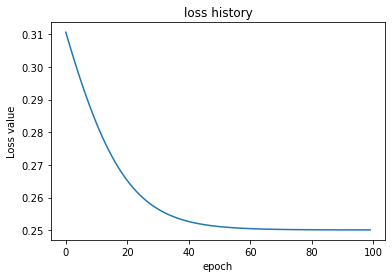

In [14]:
plt.plot(model['loss'])
plt.title('loss history')
plt.ylabel('Loss value')
plt.xlabel('epoch')
plt.show()

In [15]:
pre_line = Learner(
    Sequential(
        Linear(2, 28), 
        Sigmoid(), 
        Linear(28, 56),
        Sigmoid(),
        Linear(56, 128),
        Sigmoid(),
        Linear(128, 1),
        Sigmoid()
    ), 
    mse_loss, 
    SGDOptimizer(lr=learning_rate)
).predict(X, Y)
print(pre_line)

[[0.64553524]
 [0.64716752]
 [0.64576187]
 [0.64733815]]


In [16]:
Learner(
    Sequential(
        Linear(2, 28), 
        Sigmoid(), 
        Linear(28, 56),
        Sigmoid(),
        Linear(56, 128),
        Sigmoid(),
        Linear(128, 1),
        Sigmoid()
    ), 
    mse_loss, 
    SGDOptimizer(lr=learning_rate)
).accuracy(X, Y)

1.0